# Does a job training program improve the earnings of disadvantaged workers?

In [1]:
# Core
import numpy as np
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab

# Data
import pandas as pd
        
# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from scipy import interp

/home/daniel/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

## Introduction

**Business Context.** In the 1980s, Robert Lalonde conducted a study to evaluate the effects of training programs on labour workers. He observed the characteristic background data of the individuals involved. Several of them were selected for enrollment in the job training program (the National Supported Work Demonstration). The training program specifically targeted unemployed women, ex-drug addicts, ex-criminal offenders, and high school dropouts.

<img src="assets/trainingfailsmain.jpg" width="550" alt="Labour Training">

The Department of Labor is interested in digging deeper into this data and coming up with some actionable insights in order to raise the earnings of disadvantaged workers. They have contracted you as a data science consultant to assist them with this task.

**Business Problem.** Your goal is to evaluate **whether the job training program *causes* the earnings of disadvantaged workers to go up**.

**Analytical Context.** In this case we will continue our discussion of causal inference. We will study the importance of covariate balance and explore how to perform matching to get this balance. We will leverage a lot of the new classification models we have learned for this purpose.

## Examining the data

The Lalonde dataset provides information on annual income for workers who enroll in the training workshop and those who did not enroll in the year subsequent to training. The outcome of interest is `re78` in which we want to know if there was an increase in earnings in 1978:

1. **age**: age in years
2. **educ**: years of schooling
3. **black**: indicator variable for blacks
4. **hisp**: indicator variable for Hispanics
5. **married**: indicator variable for martial status
6. **nodegr**: indicator variable for high school diploma
7. **re74**: real earnings in 1974
8. **re75**: real earnings in 1975
9. **re78**: real earnings in 1978 - this is the outcome of interest
10. **treat**: an indicator variable for treatment status

In [3]:
lalonde_df = pd.read_csv('lalonde.csv', index_col=0)
lalonde_df.head()

treat  age  educ  black  hispan  married  nodegree  re74  re75  \
NSW1      1   37    11      1       0        1         1   0.0   0.0   
NSW2      1   22     9      0       1        0         1   0.0   0.0   
NSW3      1   30    12      1       0        0         0   0.0   0.0   
NSW4      1   27    11      1       0        0         1   0.0   0.0   
NSW5      1   33     8      1       0        0         1   0.0   0.0   

            re78  
NSW1   9930.0460  
NSW2   3595.8940  
NSW3  24909.4500  
NSW4   7506.1460  
NSW5    289.7899

In [4]:
df = lalonde_df.copy()

### Exercise 1:

#### 1.1
Load and examine the Lalonde data. Provide summary statistics for all the variables in the dataset.

**Answer:**

In [5]:
display(len(set(df.index)))
display(len(df))

614

614

In [6]:
# Write code here
df.describe()

treat         age        educ       black      hispan     married  \
count  614.000000  614.000000  614.000000  614.000000  614.000000  614.000000   
mean     0.301303   27.363192   10.268730    0.395765    0.117264    0.415309   
std      0.459198    9.881187    2.628325    0.489413    0.321997    0.493177   
min      0.000000   16.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000   20.000000    9.000000    0.000000    0.000000    0.000000   
50%      0.000000   25.000000   11.000000    0.000000    0.000000    0.000000   
75%      1.000000   32.000000   12.000000    1.000000    0.000000    1.000000   
max      1.000000   55.000000   18.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  614.000000    614.000000    614.000000    614.000000  
mean     0.630293   4557.546569   2184.938207   6792.834483  
std      0.483119   6477.964479   3295.679043   7470.730792  
min      0.000000      0.000000      0.000000      0.000000  
25%      0.000000      0.000000      0.000000    238.283425  
50%      1.000000   1042.330000    601.548400   4759.018500  
75%      1.000000   7888.498250   3248.987500  10893.592500  
max      1.000000  35040.070000  25142.240000  60307.930000

#### 1.2 
Find the difference in means and medians of earnings between the control group and the treatment group. Are these differences statistically significant?

**Answer:**

In [7]:
# Write code here
print("No treatment Group")
control = df.loc[df.treat==0][['re74','re75','re78']].describe()
display(control)
print("Treatment Group")
treatment = df.loc[df.treat==1][['re74','re75','re78']].describe()
display(treatment)
print("Difference between Treatment and Non-Treatment")
difference = control - treatment
display(difference)

No treatment Group


re74          re75          re78
count    429.000000    429.000000    429.000000
mean    5619.236506   2466.484443   6984.169742
std     6788.750796   3291.996183   7294.161791
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000    220.181300
50%     2547.047000   1086.726000   4975.505000
75%     9277.128000   3881.419000  11688.820000
max    25862.320000  18347.230000  25564.670000

Treatment Group


re74          re75          re78
count    185.000000    185.000000    185.000000
mean    2095.573689   1532.055314   6349.143530
std     4886.620353   3219.250870   7867.402218
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000    485.229800
50%        0.000000      0.000000   4232.309000
75%     1291.468000   1817.284000   9642.999000
max    35040.070000  25142.240000  60307.930000

Difference between Treatment and Non-Treatment


re74         re75          re78
count   244.000000   244.000000    244.000000
mean   3523.662818   934.429129    635.026212
std    1902.130443    72.745313   -573.240427
min       0.000000     0.000000      0.000000
25%       0.000000     0.000000   -265.048500
50%    2547.047000  1086.726000    743.196000
75%    7985.660000  2064.135000   2045.821000
max   -9177.750000 -6795.010000 -34743.260000

In [8]:
print("Difference mean:\n",difference.mean(),"\n")
print("Difference median:\n",difference.median(),"\n")

print("Control max value:\n",control.max(),"\n")
print("Treatment max value:\n",treatment.max())

Difference mean:
 re74     878.093783
re75    -299.121820
re78   -3989.188214
dtype: float64 

Difference median:
 re74    1073.065222
re75     158.372657
re78     122.000000
dtype: float64 

Control max value:
 re74    25862.32
re75    18347.23
re78    25564.67
dtype: float64 

Treatment max value:
 re74    35040.07
re75    25142.24
re78    60307.93
dtype: float64


#### 1.3

Does your previous result mean that the treatment had a negative impact? Why or why not?

**Answer:**

As we see above, the control group had more earnings represented on 1974 but les on 1975 and 1978, that could be an indicator of a good increase.

But when i see the difference in the median, we can conclude that the treatment works so good but only for a few employees, for the most is the opposite.

## Finding causal relationships

Before we start our exploration on causality, let's perform some simple setup:

1. We seperate the `treat` (treatment) indicator from our dataset. We will want to use this as our objective variable to fit models to later
2. We are interested in knowing the treatment effect on `re78` (revenue/earnings in 1978)

In [9]:
# create seperate structure for data and target 
treatment = lalonde_df['treat']
rev78 = lalonde_df['re78']
cleaned_df = lalonde_df.drop(['treat', 're78'], axis=1)

## Assessing balance between the control group and the treatment group

Suppose we want to assess whether balance has been achieved for a particular feature $x = age$. We can look at **Standardized Mean Differences (SMD)**, which is calculated by the difference in the means of the ages between the two groups divided by the pooled standard deviation.

$$\mathrm{SMD}(x)=\frac{\bar{x}_{t}-{\bar{x}_{c}}}{\sqrt{\frac{s^{2}_{t} + s^{2}_{c}}{2}}}.$$
 
The following explains the notation in the above equation:

1. $(\bar{x}_{t}$, $\bar{x}_{c}$) denotes the mean of that feature (in our example, the age) for the treatment and control group respectively. Note that people often times report the absolute value of this number.
2. ($s^{2}_{t}$, $s^{2}_{c}$)  denotes the standard deviation of that feature for the treatment and control group respectively. For the denominator we are just pooling standard deviation.
We can calculate the standardized mean differences for every feature. If our calculated SMD is 1, then that means there's a 1 standard deviation difference in means. The benefit of having standard deviation in the denominator is that this number becomes insensitive to the scale of the feature. 

After computing this measurement for all of our features, there is a rule of thumb that is commonly used to determine whether that feature is balanced or not (similar to the idea of using 0.05 as a threshold for $p$ - values):

1. **SMD < 0.1**: For a **randomized trial**, the SMD between all of the covariates should typically fall into this bucket.
2. **SMD is between 0.1 and 0.2**:  Not necessarily balanced, but small enough that people are usually not too worried about them. Sometimes, even after performing matching, there might still be a few covariates whose SMD fall under this range.
3. **SMD > 0.2**: Values that are greater than this threshold are considered seriously imbalanced.

### Exercise 2:

#### 2.1

Assess covariate balance between the treatment and control groups. What features (covariates) are imbalanced between the control group and the treatment group in this dataset?

**Answer:**

In [10]:
# Write code here
smd = {}
inbalanced_vars = []
for var in df.drop(columns=['treat','re78']).columns:
    if len(set(df[var]))>10:
        xt = df.loc[df.treat==1,var].mean()
        xc = df.loc[df.treat==0,var].mean()
        st2 = df.loc[df.treat==1,var].var()
        sc2 = df.loc[df.treat==0,var].var()
        smd_var = np.round( np.abs(xt-xc) / (np.sqrt( (st2+sc2)/2  )),3)
        smd[var] = smd_var


print('\nImbalanced features (SMD > 0.2):\n')
for k,i in zip(smd,smd.values()):
    if (i>0.2):
        print(k,i)
        inbalanced_vars.append(k)



Imbalanced features (SMD > 0.2):

age 0.242
re74 0.596
re75 0.287


#### 2.2

Make plots which show the histograms for both the treatment and control groups of the imbalanced covariates.

**Answer:**

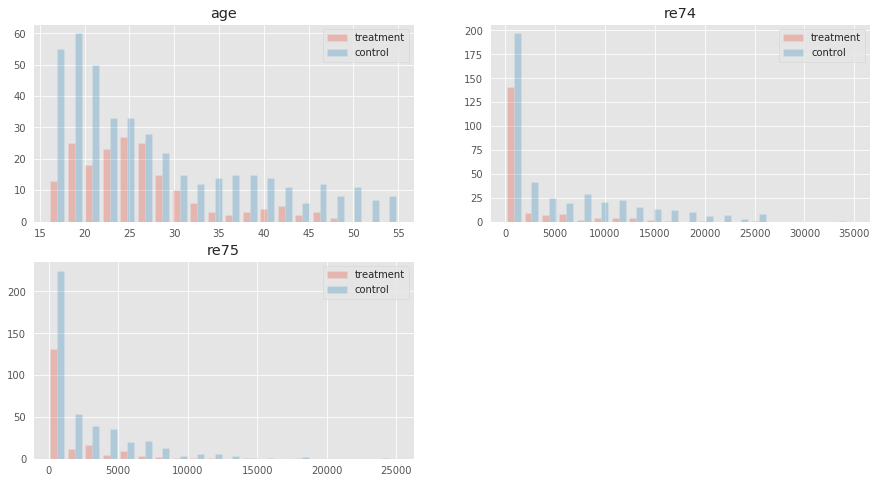

In [11]:
# Write code here
fig1 = plt.figure(figsize=(15,8))
for i,k in enumerate(inbalanced_vars):    
    plt.subplot(2,2,i+1)
    labels=['treatment','control']
    plt.hist((df.loc[df.treat==1,k],df.loc[df.treat==0,k]),stacked=False,bins=20,alpha=0.3)
    plt.title(k)
    plt.legend(labels)



## Matching

**Matching** can be defined as any method that *strategically subsamples* a dataset with the aim of balancing observable covariate distributions between the treatment and control groups. It is one of several statistical techniques that emerged in the 1980s with the aim of estimating causal effects. 

Note that matching is not a standalone estimation technique by itself; rather, it is a pre-processing step that prepares the data for further analysis. In this particular situation, the challenge is that we are trying to perform matching when there are many features present in the data, so it is not clear which ones to match on.

### Exercise 3:

Why can we not just match on all of the features, rather than selected ones? Wouldn't this control for differences between the control and treatment groups most effectively?

**Answer:**

Is important to look what features can distorsionate our model because are imbalanced or not, also without a good prediction or the propensity score, is hard to determine if the target variable is matched or if the objective is reached

__________

In this context, a metric called the **propensity score** helps us do the matching on select features in an efficient way. The key idea is that *the features that are correlated with the probability of a worker being selected into the treatment group affecting our causal results*. A propensity score is this probability. The propensity score for subject $i$, denoted as $\pi_i$ is defined as:

$\pi_i$ = P(Subject $i$ is given training given their features $X_i$)
 
As an example, if a person had a propensity score of 0.3, that would mean that given their particular covariates, there was a 30% chance that they were placed in the treatment group. We can calculate this score by fitting a classification model to our data, where the input features are our covariates, and the output is whether that person was part of the treatment group or not.

### Exercise 4:

Estimate the propensity scores using logistic regression; i.e. build a logistic regression model where the outcome variable is whether a subject was in the treatment group or not, and the covariates are all the other variables except `re78`. The predicted probabilities are the propensity scores; call these the **pscores**. We are going to use them later.

**Answer:**

In [12]:
# Write code here
formula='treat ~' + '+'.join(each for each in df.drop(columns =['treat','re78']).columns )

propensity = smf.logit(formula=formula,data=df).fit()
display(propensity.summary())
pscore= propensity.predict()


Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Fri, 29 Nov 2019   Pseudo R-squ.:                  0.3508
Time:                        10:10:57   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7286      1.017     -4.649      0.000      -6.722      -2.735
age            0.0158      0.014      1.162      0.245      -0.011       0.042
educ           0.1613      0.065      2.477      0.013       0.034       0.289
black          3.0654      0.287     10.698      0.000       2.504       3.627
hispan         0.9836      0.426      2.311      0.021       0.149       1.818
married       -0.8321      0.290     -2.866      0.004      -1.401      -0.263
nodegree       0.7073      0.338      2.095      0.036       0.045       1.369
re74       -7.178e-05   2.87e-05     -2.497      0.013      -0.000   -1.54e-05
re75        5.345e-05   4.63e-05      1.153      0.249   -3.74e-05       0.000
==============================================================================
"""

In [13]:
df['propensity'] = pscore
df.propensity.head(10)

NSW1     0.638770
NSW2     0.224634
NSW3     0.678244
NSW4     0.776324
NSW5     0.701639
NSW6     0.699070
NSW7     0.653684
NSW8     0.789723
NSW9     0.779838
NSW10    0.042925
Name: propensity, dtype: float64

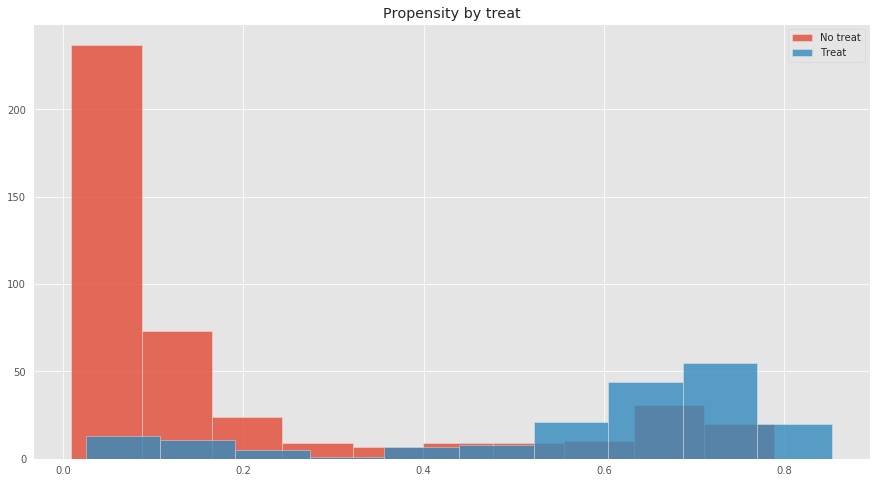

In [14]:
plt.figure(figsize=(15,8))
df.groupby('treat')['propensity'].hist(alpha=0.8)
plt.legend(['No treat','Treat'])
plt.title('Propensity by treat');

## Matching using $k$-nearest neighbors

We are going to match treated and control subjects using nearest neighbor matching on the estimated propensity score.
Here we use another popular clustering algorithm: the **$k$-nearest neighbors ($k$-NN) algorithm**.

In [15]:
targets = treatment

In [16]:
# we seperate the pscore based on it's 
# corresponding true label value
# remember pscore comes from your answer for question 5.
tags = targets.squeeze() == 1
pos_pscore = pscore[tags]
neg_pscore = pscore[~tags]

In [17]:
# Define params and inputs
mask = lalonde_df['treat'] == 1
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
agg_operations = {'treat': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in covariates
})

In [18]:
from sklearn.neighbors import NearestNeighbors

# Helper function that uses K-NN algorithm to calculate 
# the similarity distance from propensity score 
# and the corresponding similarity indices for the purpose of matching later
def get_similar(pos_pscore, neg_pscore, topn=5, n_jobs=1):
    knn = NearestNeighbors(n_neighbors=topn, 
                           metric='euclidean',
                           n_jobs=n_jobs)
    knn.fit(neg_pscore.reshape(-1, 1))
    
    distances, indices = knn.kneighbors(pos_pscore.reshape(-1, 1))
    sim_distances = distances[:, :]
    sim_indices = indices[:, :]

    return sim_distances, sim_indices

In [19]:
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)

In [20]:
# Display matching table
df_pos = lalonde_df[mask]
df_neg = lalonde_df[~mask].iloc[sim_indices[:, 0]]
df_matched_join = (df_pos.reset_index(drop=True)
              .merge(df_neg.reset_index(drop=True), 
                     left_index=True, 
                     right_index=True))

num_matched_pairs = df_neg.shape[0]

print('Number of matched pairs: ', num_matched_pairs)

Number of matched pairs:  185


In [21]:
df_matched_join

treat_x  age_x  educ_x  black_x  hispan_x  married_x  nodegree_x  \
0          1     37      11        1         0          1           1   
1          1     22       9        0         1          0           1   
2          1     30      12        1         0          0           0   
3          1     27      11        1         0          0           1   
4          1     33       8        1         0          0           1   
..       ...    ...     ...      ...       ...        ...         ...   
180        1     33      12        1         0          1           0   
181        1     25      14        1         0          1           0   
182        1     35       9        1         0          1           1   
183        1     35       8        1         0          1           1   
184        1     33      11        1         0          1           1   

       re74_x    re75_x      re78_x  treat_y  age_y  educ_y  black_y  \
0        0.00      0.00   9930.0460        0     30      17        1   
1        0.00      0.00   3595.8940        0     51      11        0   
2        0.00      0.00  24909.4500        0     16       9        1   
3        0.00      0.00   7506.1460        0     39      10        1   
4        0.00      0.00    289.7899        0     19       9        1   
..        ...       ...         ...      ...    ...     ...      ...   
180  20279.95  10941.35  15952.6000        0     18      11        0   
181  35040.07  11536.57  36646.9500        0     26      12        0   
182  13602.43  13830.64  12803.9700        0     34      12        1   
183  13732.07  17976.15   3786.6280        0     47       8        1   
184  14660.71  25142.24   4181.9420        0     23      13        1   

     hispan_y  married_y  nodegree_y       re74_y     re75_y      re78_y  
0           0          0           0  17827.37000  5546.4190  14421.1300  
1           0          0           1     48.98167  3813.3870   1525.0140  
2           0          0           1      0.00000     0.0000   2158.9590  
3           0          0           1    844.44400   889.7903    701.9201  
4           0          0           1   1079.55600  2873.4680  14344.2900  
..        ...        ...         ...          ...        ...         ...  
180         1          0           1      0.00000   630.1935      0.0000  
181         1          0           0   7968.33800  5109.5810   4181.9660  
182         0          1           0      0.00000     0.0000  18716.8800  
183         0          1           1   9275.16900  8543.4190      0.0000  
184         0          0           0    172.41550   272.1290    582.2243  

[185 rows x 20 columns]

## Propensity score distribution plot after matching

Let's take a glance at the distribution of propensity score after matching. Both groups have similar distributions on the propensity score. This means we have reach a balance in both groups. This enables us to further analyse the causality effect of the treatment.

### Exercise 5:

Make a plot which shows histograms of propensity scores for the control and treatment groups after matching using the $k$ - NN code given above.

**Answer:**

In [22]:
plt.figure(figsize=(15,8))
plt.hist((df_matched_join['re78_x'],df_matched_join['re78_y']),bins=20,stacked=False,alpha=0.3,label=['treat','control']);
plt.legend(fontsize=16);
plt.title('Propensity scores for treat and control group');

### Exercise 6:

Assess covariate balance after the $k$-NN matching.  For this, compute the absolute standardized differences in means in the covariates after matching,  $$ASMD_a(x)=\frac{\bar{x}_{t,a}-{\bar{x}_{c,a}}}{\sqrt{\frac{s^{2}_{t,b} + s^{2}_{c,b}}{2}}},$$ where $\bar{x}_{t,a}$ and $\bar{x}_{c,a}$ are, respectively, the means of covariate $x$ in the treatment and control groups after matching, and $s^{2}_{t,b}$ and $s^{2}_{c,b}$ are, correspondingly, the sample variances treatment and control groups before matching. 

One reason to use the sample variances before matching rather than the sample variances after matching is to free the comparisons of the means after matching from simultaneous changes in the variances. Comment on covariate balance.

**Answer:**

In [23]:
len(set(df.educ))

19

In [24]:
# Write code here
num_features = []
for var in df.drop(columns=['treat','re78','propensity']):
    if len(set(df[var]))>10:
        num_features.append(var)
num_features


['age', 'educ', 're74', 're75']

In [25]:
asmd = {}
for feat in num_features:
    xta = df_matched_join[feat+'_x'].mean()
    xca = df_matched_join[feat+'_y'].mean()
    stb = df.loc[df.treat==1,feat].var()
    scb = df.loc[df.treat==0,feat].var()
    
    ftasmd = np.abs(xta-xca)/np.sqrt((stb+scb)/2 )
    asmd[feat] = round(ftasmd,3)

    

In [26]:
asmd

{'age': 0.187, 'educ': 0.013, 're74': 0.041, 're75': 0.009}

It seems that covariate balance is much better, as all but two of the variables have SMD less than 0.1, and all but one has SMD less than 0.2 (and the remaining one is right on the cusp).

________

If we look once again at the histograms of several covariates after we apply matching, we can see a marked improvement in the similarity of the histograms of the control and treatment groups:

In [27]:
df_matched = pd.concat((df_pos,df_neg))
df_matched

treat  age  educ  black  hispan  married  nodegree       re74  \
NSW1         1   37    11      1       0        1         1     0.0000   
NSW2         1   22     9      0       1        0         1     0.0000   
NSW3         1   30    12      1       0        0         0     0.0000   
NSW4         1   27    11      1       0        0         1     0.0000   
NSW5         1   33     8      1       0        0         1     0.0000   
...        ...  ...   ...    ...     ...      ...       ...        ...   
PSID239      0   18    11      0       1        0         1     0.0000   
PSID76       0   26    12      0       1        0         0  7968.3380   
PSID380      0   34    12      1       0        1         0     0.0000   
PSID24       0   47     8      1       0        1         1  9275.1690   
PSID269      0   23    13      1       0        0         0   172.4155   

              re75        re78  
NSW1        0.0000   9930.0460  
NSW2        0.0000   3595.8940  
NSW3        0.0000  24909.4500  
NSW4        0.0000   7506.1460  
NSW5        0.0000    289.7899  
...            ...         ...  
PSID239   630.1935      0.0000  
PSID76   5109.5810   4181.9660  
PSID380     0.0000  18716.8800  
PSID24   8543.4190      0.0000  
PSID269   272.1290    582.2243  

[370 rows x 10 columns]

In [28]:
df_matched.loc[df_matched.treat==1,'treat'] = 'treat'
df_matched.loc[df_matched.treat==0,'treat'] = 'control'

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(15,6))

# plot income distribution for 1978
ax1, _ = df_matched.groupby('treat')['re78'].plot(kind='hist', 
                                         bins=20, alpha=0.5, legend=True,
                                         ax=ax1)
ax1.set_xlabel("Earnings in 1978");

# plot income distribution for 1974
ax2, _ = df_matched.groupby('treat')['re74'].plot(kind='hist', 
                                              bins=20, alpha=0.5, legend=True,
                                              ax=ax2)
ax2.set_xlabel("Earnings in 1974");        # set title for y axis

# plot education distribution
ax3, _ = df_matched.groupby('treat')['educ'].plot(kind='hist',
                                     bins=20, alpha=0.5, legend=True,
                                     ax=ax3)
ax3.set_xlabel("Year of Schooling");        # set title for y axis

### Exercise 7:

Estimate the average effect of treatment on the treated after matching. What do you conclude?

**Answer:**

In [43]:
print('Before balance covariates')
print('treat re78 mean : {}'.format(round(df.loc[df.treat==1,'re78'].mean(),3)))
print('control re78 mean : {}'.format(round(df.loc[df.treat==0,'re78'].mean(),3)))

Before balance covariates
treat re78 mean : 6349.144
control re78 mean : 6984.17


In [44]:
# Write code here
print('After balance covariates')
print('treat re78 mean : {}'.format(round(df_matched.loc[df_matched.treat=='treat','re78'].mean(),3)))
print('control re78 mean : {}'.format(round(df_matched.loc[df_matched.treat=='control','re78'].mean(),3)))

After balance covariates
treat re78 mean : 6349.144
control re78 mean : 4560.184


If we are only watching the mean of treat and control groups, we can see how the treat group got an increase of the real earnings in that year

### Exercise 8:

#### 8.1

Estimate the propensity scores now by using random forests. What is the AUC for your random forest model?

**Answer:**

In [31]:
X = lalonde_df.drop(columns=['treat','re78'])
y = lalonde_df.treat
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
clf_rf.fit( X , y )
clf_rf_probas = clf_rf.predict_proba( X )

In [32]:
rf_roc = roc_curve( y , clf_rf_probas[:,1])
auc_p = auc( rf_roc[0],rf_roc[1])

In [33]:
print(f'The AUC for the random forst model is :{round(auc_p,3)}')

The AUC for the random forst model is :0.917


#### 8.2

Repeat the matching procedure now with the estimated propensity scores using the random forest classifier.

**Answer:**

In [34]:
pscore = clf_rf.predict(X)

In [35]:
tags = targets.squeeze() == 1
pos_pscore = pscore[tags]
neg_pscore = pscore[~tags]

In [36]:
# Define params and inputs
mask = lalonde_df['treat'] == 1
covariates = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']
agg_operations = {'treat': 'count'}
agg_operations.update({
    feature: ['mean', 'std'] for feature in covariates
})

In [37]:
sim_distances, sim_indices = get_similar(pos_pscore, neg_pscore, topn=1)

In [38]:
# Display matching table
df_pos = lalonde_df[mask]
df_neg = lalonde_df[~mask].iloc[sim_indices[:, 0]]
df_matched_join = (df_pos.reset_index(drop=True)
              .merge(df_neg.reset_index(drop=True), 
                     left_index=True, 
                     right_index=True))

num_matched_pairs = df_neg.shape[0]

print('Number of matched pairs: ', num_matched_pairs)

Number of matched pairs:  185


In [39]:
df_matched_join

treat_x  age_x  educ_x  black_x  hispan_x  married_x  nodegree_x  \
0          1     37      11        1         0          1           1   
1          1     22       9        0         1          0           1   
2          1     30      12        1         0          0           0   
3          1     27      11        1         0          0           1   
4          1     33       8        1         0          0           1   
..       ...    ...     ...      ...       ...        ...         ...   
180        1     33      12        1         0          1           0   
181        1     25      14        1         0          1           0   
182        1     35       9        1         0          1           1   
183        1     35       8        1         0          1           1   
184        1     33      11        1         0          1           1   

       re74_x    re75_x      re78_x  treat_y  age_y  educ_y  black_y  \
0        0.00      0.00   9930.0460        0     20      11        1   
1        0.00      0.00   3595.8940        0     21      12        0   
2        0.00      0.00  24909.4500        0     20      11        1   
3        0.00      0.00   7506.1460        0     20      11        1   
4        0.00      0.00    289.7899        0     20      11        1   
..        ...       ...         ...      ...    ...     ...      ...   
180  20279.95  10941.35  15952.6000        0     21      12        0   
181  35040.07  11536.57  36646.9500        0     21      12        0   
182  13602.43  13830.64  12803.9700        0     21      12        0   
183  13732.07  17976.15   3786.6280        0     21      12        0   
184  14660.71  25142.24   4181.9420        0     21      12        0   

     hispan_y  married_y  nodegree_y    re74_y    re75_y    re78_y  
0           0          0           1     0.000  3480.387  5495.665  
1           0          0           0  2827.222  4056.871  5937.505  
2           0          0           1     0.000  3480.387  5495.665  
3           0          0           1     0.000  3480.387  5495.665  
4           0          0           1     0.000  3480.387  5495.665  
..        ...        ...         ...       ...       ...       ...  
180         0          0           0  2827.222  4056.871  5937.505  
181         0          0           0  2827.222  4056.871  5937.505  
182         0          0           0  2827.222  4056.871  5937.505  
183         0          0           0  2827.222  4056.871  5937.505  
184         0          0           0  2827.222  4056.871  5937.505  

[185 rows x 20 columns]

#### 8.3

Give the table showing the balance of covariates. What do you get the treatment effect to be in this case?

**Answer:**

In [40]:
# Write code here
asmdRF = {}
for feat in num_features:
    xta = df_matched_join[feat+'_x'].mean()
    xca = df_matched_join[feat+'_y'].mean()
    stb = df.loc[df.treat==1,feat].var()
    scb = df.loc[df.treat==0,feat].var()
    
    ftasmd = np.abs(xta-xca)/np.sqrt(   (stb+scb)/2 )
    asmdRF[feat] = round(ftasmd,3)

In [41]:
pd.DataFrame({'LR':asmd,'RF':asmdRF})

LR     RF
age   0.187  0.594
educ  0.013  0.418
re74  0.041  0.173
re75  0.009  0.665

With Logistic Regression the covariates are most balanced than the random forest